In [9]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns

%matplotlib inline

plt.style.use('ggplot')
sns.set_context('talk')

## Bayesian A/B Testing

The following code is adapted from [Probabilistic Programming and Bayesian Methods for Hackers](https://nbviewer.jupyter.org/github/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter4_TheGreatestTheoremNeverTold/Ch4_LawOfLargeNumbers_PyMC3.ipynb).

In [18]:
def posterior_conversion_rate(converted, bounced, samples=20000):
    N = converted + bounced
    with pm.Model() as model:
        conversion_rate = pm.Uniform("conversion_rate", 0, 1)
        observations = pm.Binomial("obs", N, conversion_rate, observed=converted)
        
        trace = pm.sample(samples, tune=2000, step=pm.Metropolis())
    
    burned_trace = trace[int(samples/4):]
    return burned_trace["conversion_rate"]

Let's take some samples!

In [19]:
a = posterior_conversion_rate(1200, 800)
b = posterior_conversion_rate(1250, 750)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [conversion_rate]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:10<00:00, 8106.36draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [conversion_rate]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:10<00:00, 7463.14draws/s]
The acceptance probability does not match the target. It is 0.8954461149196811, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8879310981717526, but should be close to 0.8. Try to increase the number of tuning steps.


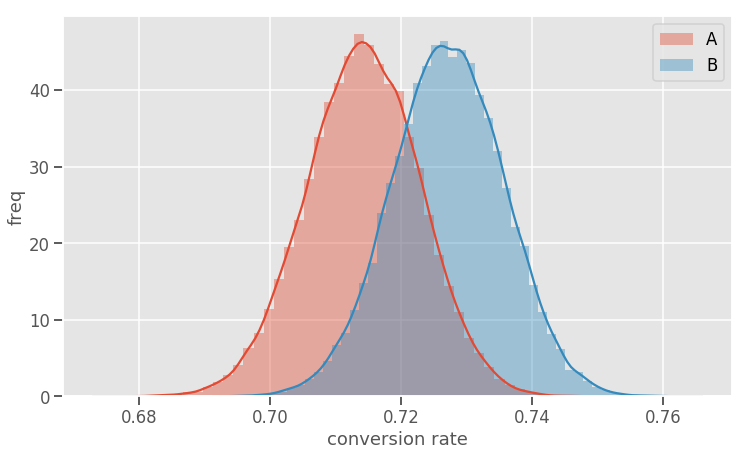

In [21]:
fig, ax = plt.subplots(figsize=(12,7))
sns.distplot(a, label='A', ax=ax)
sns.distplot(b, label='B', ax=ax)
plt.xlabel('conversion rate')
plt.ylabel('freq')
plt.legend();

Let's do it ourselves so we can actually modify the results as we want. In this case, we reframe the problem from $p(a > b)$ to $p(a-b > 0)$.

In [70]:
converted_a = 1200
converted_b = 1250
bounced_a = 800
bounced_b = 750
N_a = converted_a + bounced_a
N_b = converted_b + bounced_b
samples = 20000

with pm.Model() as model:
    ctp_a = pm.Beta("ctp_a", 1, 1)
    ctp_b = pm.Beta("ctp_b", 1, 1)
    obs_a = pm.Binomial("obs_a", N_a, ctp_a, observed=converted_a)
    obs_b = pm.Binomial("obs_b", N_b, ctp_b, observed=converted_b)
    a_diff_b = pm.Deterministic('a-b', ctp_a - ctp_b)

    trace = pm.sample(samples, step=pm.Metropolis())

burned_trace = trace[int(samples/4):]

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [ctp_b]
>Metropolis: [ctp_a]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:08<00:00, 9833.27draws/s]
The number of effective samples is smaller than 10% for some parameters.


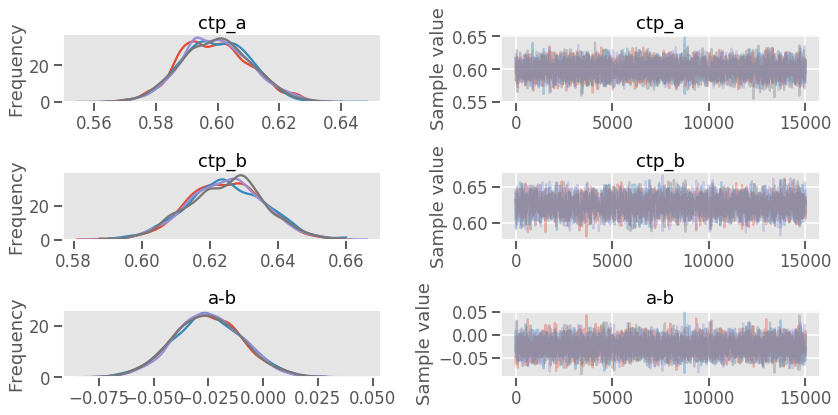

In [71]:
pm.traceplot(burned_trace);

The following figure shows that the mean of $CTP_B$ is larger thatn $CTP_A$, but is it always the case that $CTP_B > CTP_A$?

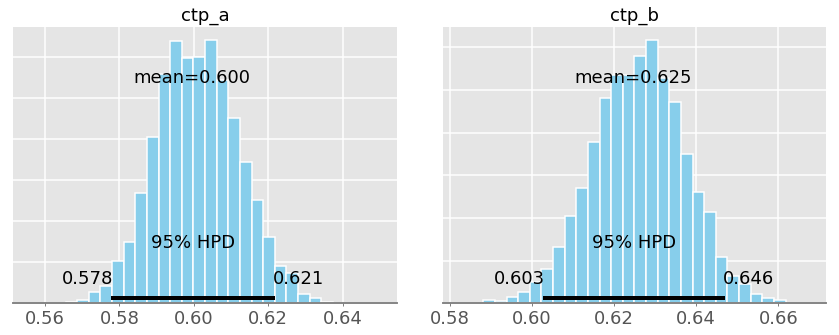

In [72]:
pm.plot_posterior(burned_trace, varnames=['ctp_a', 'ctp_b'], figsize=(12,5), text_size=18);

It turns out, we can just subtract both CTPs! The interpretation of the following figure should be quite intuitive: the probability of seeing option A gets more conversion than option B is only 0.0568 which means it is more likely to see the opposite!

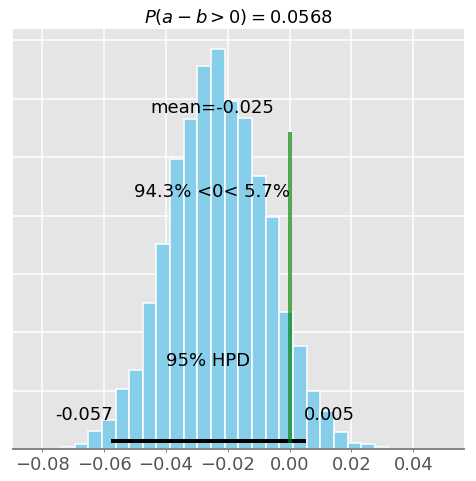

In [75]:
pm.plot_posterior(
    burned_trace,
    varnames=['a-b'],
    ref_val=0,
    figsize=(7,7),
    text_size=18
)
plt.title('$P(a-b > 0) = {:.4f}$'.format(
    (burned_trace['a-b'] > 0).mean()
));

## Bayesian Search Ranking

First, we will generate a random dataset.

In [2]:
np.random.seed(42)

no_prop = 10
all_ratings = pd.DataFrame()

for i in range(no_prop):
    no_ratings = max(0, int(40*np.random.standard_t(3)+50))
    ratings = pd.DataFrame({
        'property_id': [i] * no_ratings,
        'rating': np.round(10*np.random.beta(7, 2, size=no_ratings), 0)
    })
    all_ratings = pd.concat([
        all_ratings,
        ratings
    ])

Now, let's report the summary statistics. Also, order the properties based on their average rating.

In [3]:
agg_review = all_ratings.groupby('property_id').agg({
    'rating': ['mean', 'std', 'sum', 'count']
}).rating.reset_index()

agg_review[['property_id','mean','std','count']].sort_values('mean', ascending=False).reset_index(drop=True).style.format({
    'mean': '{:.2f}',
    'std': '{:.2f}'
})

,property_id,mean,std,count
0,4,8.25,1.24,16
1,8,8.11,0.98,36
2,5,8.03,1.21,29
3,1,7.87,1.34,91
4,3,7.84,1.12,51
5,6,7.84,1.36,114
6,7,7.70,1.34,20
7,9,7.50,1.35,10
8,0,7.46,1.42,74
9,2,7.42,1.56,24


We can dig deeper in this problem. Let's take two example properties: prop 3 and 6. Our "usual" solution will look like the following figure.

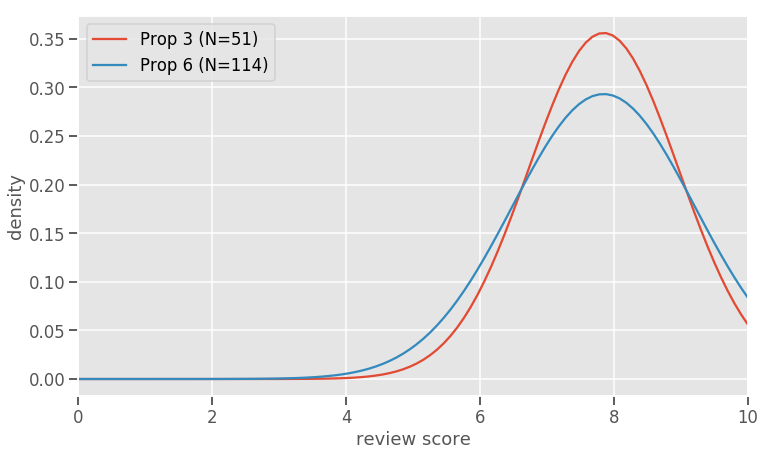

In [4]:
from scipy.stats import norm

def draw_norm(property_id, ax):
    prop = all_ratings.query('property_id == {}'.format(property_id))
    no_ratings = len(prop)

    x = np.linspace(0, 1, 100)
    ax.plot(
        x*10,
        norm.pdf(x*10, prop.rating.mean(), prop.rating.std()),
        label='Prop {} (N={})'.format(property_id, len(prop))
    )

fig, ax = plt.subplots(figsize=(12,7))
draw_norm(3, ax)
draw_norm(6, ax)
plt.xlim([0,10])
plt.xlabel('review score')
plt.ylabel('density')
plt.legend();

You can see in the previous figure that we don't really take N into account. We should be more certain when we see larger number of samples. What can we do to incorporate this? Use beta distribution!

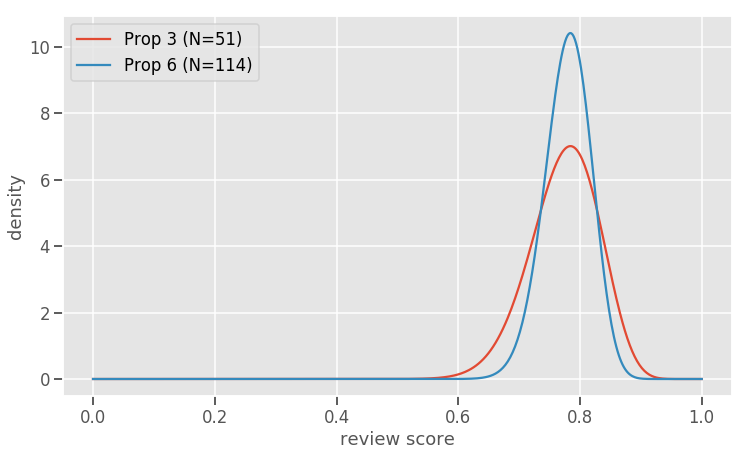

In [5]:
from scipy.stats import beta

def draw_beta(property_id, ax):
    prop = all_ratings.query('property_id == {}'.format(property_id))
    no_ratings = len(prop)

    x = np.linspace(0, 1, 500)
    ax.plot(
        x,
        beta.pdf(x, 1+prop.rating.sum()/10, 1+no_ratings-prop.rating.sum()/10),
        label='Prop {} (N={})'.format(property_id, len(prop))
    )
    
fig, ax = plt.subplots(figsize=(12,7))
draw_beta(3, ax)
draw_beta(6, ax)
plt.xlabel('review score')
plt.ylabel('density')
plt.legend();

Prop 6 which has more ratings is more certain about the true review score! Yay! However, as we are recommending our properties to our customers, and we consider ourselves customer-centric, we should be more cautious, no?

Therefore, we can use the *95% least plausible value*.

> Why is sorting based on this quantity a good idea? By ordering by the 95% least plausible value, we are being the most conservative with what we think is best. [(Davidson-Pilon, 2015)](https://nbviewer.jupyter.org/github/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter4_TheGreatestTheoremNeverTold/Ch4_LawOfLargeNumbers_PyMC3.ipynb)

### The Exploratory Code

We can use a similar codebase to the one we've written before!

In [64]:
def posterior_score(N, sum_of_ratings, samples=20000):
    gap_from_perfect_ratings = N - sum_of_ratings
    with pm.Model() as model:
        true_score = pm.Uniform("true_score", 0, 1)
        observations = pm.Binomial("obs", N, true_score, observed=sum_of_ratings)
        
        trace = pm.sample(samples, tune=1000, progressbar=False)
    
    burned_trace = trace[int(samples/4):]
    return burned_trace["true_score"]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [true_score]
The acceptance probability does not match the target. It is 0.8964733253472871, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [true_score]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [true_score]


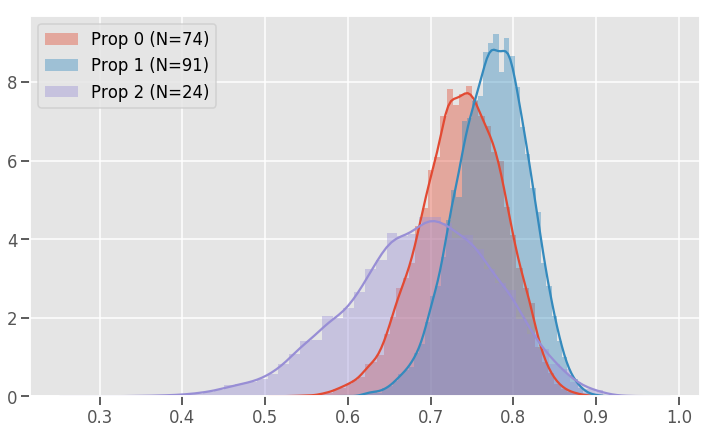

In [67]:
from tqdm import tqdm_notebook as tqdm

fig, ax = plt.subplots(figsize=(12,7))
for i, row in tqdm(agg_review.sample(3).iterrows(), leave=False):
    true_score = posterior_score(row['count'], row['sum']/10, 5000)
    sns.distplot(true_score, label='Prop {} (N={})'.format(int(row['property_id']), int(row['count'])), ax=ax)
plt.legend();

### The Production-friendly Code

The following code is from the analytical solution, i.e. deriving the posterior distribution and using the normal/Gaussian distribution approximation to the beta distribution.

In [6]:
def lower_bound(a, b):
    mean = a / (a + b)
    stdev = 1.65 * np.sqrt((a*b)/((a+b)**2 * (a + b + 1)))
    return mean, stdev

In [7]:
agg_review['mle'] = agg_review['mean']
posterior_mean, std_err = zip(*agg_review.apply(lambda x: lower_bound(1+x['sum']/10, 1+x['count']-x['sum']/10), axis=1))
agg_review['lower'] = pd.Series(posterior_mean) - pd.Series(std_err)
agg_review['posterior_mean'] = (1+agg_review['sum']/10)/(2+agg_review['count'])
agg_review['std_err'] = std_err

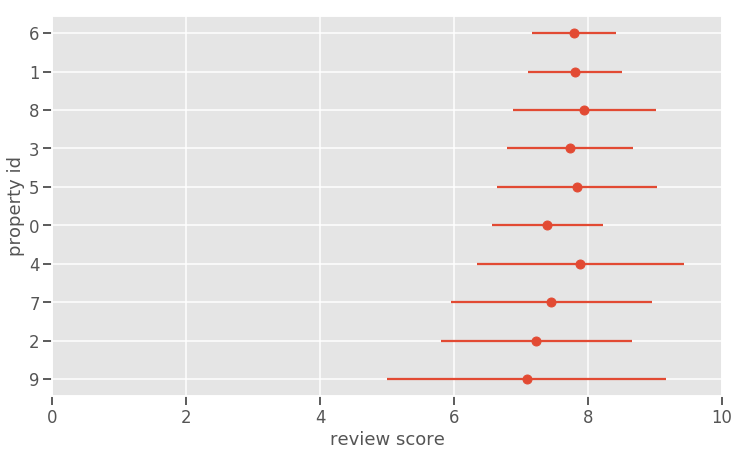

In [8]:
order = np.argsort(agg_review['lower']).values
fig, ax = plt.subplots(figsize=(12,7))
ax.errorbar(
    agg_review.iloc[order]['posterior_mean']*10, np.arange(len(order)),
    xerr=agg_review.iloc[order]['std_err']*10, capsize=0, fmt='o'
)
plt.xlim([0,10])
plt.yticks(range(len(agg_review)), agg_review.iloc[order]['property_id'])
plt.xlabel('review score')
plt.ylabel('property id');